# Extend, plugin, contribution patterns - interaction and integration

Sktime and has a comprehensive set of features, but we might want to create new features and customize certain behaviours. This notebook will show how to extend sktime by creating new transformations and forecasters, and how to contribute to the project (directly, or indirectly).

## Agenda

1. [Extending sktime](#Extending-sktime)
    1. [Overview of the interface](#Overview-of-the-interface)
    2. [The tag system](#The-tag-system)
    3. [Implementing a new forecaster](#Implementing-a-new-forecaster)
    4. [Implementing a new transformer](#Implementing-a-new-transformer)
2. [Contributing to sktime](#Contributing-to-sktime)

## 1. Extending sktime

**Motivation**

<img src="imgs/sockets.png" alt="Sockets" width="300" />

### 1.1. Overview of the interface

* The main classes are `BaseTransformer` and `BaseForecaster`. 
* Transformations have three core public methods, besides `__init__` that sets the hyperparameters:
    - `fit(X, y)`: to learn from the data
    - `transform(X, y)`: to apply the transformation
    - `inverse_transform(X, y)`: to reverse the transformation
* Forecasters have two public methods:
    - `fit(y, X)`: to learn from the data
    - `predict(fh, X)`: to make predictions
* We implement their private pairs: `_fit`, `_transform`, `_inverse_transform`, `_predict`. 

![](imgs/private_methods.png)

### 1.2. The tag system

The things that happen between the call of the public methods and the private methods are defined by the tags. Tags are metadata that indicate to the base classes `BaseForecaster` and `BaseTransformer` what validations and preprocessing are needed before calling the inner implementation.

Most important tags:

**Forecasters**

```python
_tags = {
        # Model metadata
        "ignores-exogeneous-X": True,
        "requires-fh-in-fit": False,
        "X_inner_mtype": [
            "pd.Series",
            "pd.DataFrame",
            "pd-multiindex",
            "pd_multiindex_hier",
        ],
        "y_inner_mtype": [
            "pd.Series",
            "pd.DataFrame",
            "pd-multiindex",
            "pd_multiindex_hier",
        ],
        "scitype:y": "univariate",
    }

```

#### Forecasters "mtype" tags



Available mtypes:
- `np.ndarray`
- `pd.Series`
- `pd.DataFrame`
- `pd-multiindex` <- for panel data
- `pd_multiindex_hier` <- for hierarchical data


In [1]:
# import to retrieve examples
from sktime.datatypes import get_examples

get_examples(mtype="np.ndarray", as_scitype="Series")[0]

array([[ 1. ],
       [ 4. ],
       [ 0.5],
       [-3. ]])

In [2]:
get_examples(mtype="pd.DataFrame", as_scitype="Series")[0]

,a
0,1.0
1,4.0
2,0.5
3,-3.0


In [3]:
get_examples(mtype="pd-multiindex", as_scitype="Panel")[0].head()

var_0  var_1
instances timepoints              
0         0               1      4
          1               2      5
          2               3      6
1         0               1      4
          1               2     55

In [4]:
get_examples(mtype="pd_multiindex_hier", as_scitype="Hierarchical")[0].head()

var_0  var_1
foo bar timepoints              
a   0   0               1      4
        1               2      5
        2               3      6
    1   0               1      4
        1               2     55



* **Some mtypes have limitations**: a simple `pd.Series` cannot represent data for hierarchical forecasting problem. In this case, we need to use `pd_multiindex_hier`.

* Sktime converts to the correct mtype when possible:

![](imgs/mtype_example.png)


Let's see that in action:



In [5]:
import warnings
warnings.filterwarnings("ignore")

#### Single series as input

In [6]:
from sktime.forecasting.base import BaseForecaster
from sktime.utils._testing.series import _make_series

y = _make_series(4)
y


2000-01-01    1.794710
2000-01-02    4.792570
2000-01-03    2.263684
2000-01-04    1.000000
Freq: D, dtype: float64

In [7]:


class Logger(BaseForecaster):

    _tags = {
        "requires-fh-in-fit": False,
    }

    def __init__(self, tags_to_set):
        self.tags_to_set = tags_to_set
        super().__init__()

        self.set_tags(**tags_to_set)
    
    def _fit(self, y, X=None, fh=None):
        print("Inside fit:")
        print(y)
        return self
    


In [8]:
logger = Logger(tags_to_set={"y_inner_mtype" : ["pd.Series"] })
logger.fit(y)

Inside fit:
2000-01-01    1.794710
2000-01-02    4.792570
2000-01-03    2.263684
2000-01-04    1.000000
Freq: D, dtype: float64


Logger(tags_to_set={'y_inner_mtype': ['pd.Series']})

In [9]:
logger = Logger(tags_to_set={"y_inner_mtype" : ["np.ndarray"] })
logger.fit(y)

Inside fit:
[[1.79470988]
 [4.79256965]
 [2.26368367]
 [1.        ]]


Logger(tags_to_set={'y_inner_mtype': ['np.ndarray']})

In [10]:
logger = Logger(tags_to_set={"y_inner_mtype" : ["pd.DataFrame"] })
logger.fit(y)

Inside fit:
                   0
2000-01-01  1.794710
2000-01-02  4.792570
2000-01-03  2.263684
2000-01-04  1.000000


Logger(tags_to_set={'y_inner_mtype': ['pd.DataFrame']})

In [11]:

try:
    logger = Logger(tags_to_set={"y_inner_mtype" : ["pd_multiindex_hier"] })
    logger.fit(y)
except ValueError as e:
    print(e)


Error in Logger, no series scitypes supported, likely a bug in estimator: scitypes arg passed to _most_complex_scitype are ['Hierarchical']


In [12]:
try:
    logger = Logger(tags_to_set={"y_inner_mtype": ["pd.DataFrame", "pd_multiindex_hier"]})
    logger.fit(y)
except ValueError as e:
    print(e)

Inside fit:
                   0
2000-01-01  1.794710
2000-01-02  4.792570
2000-01-03  2.263684
2000-01-04  1.000000


#### Hierarchical input?

In [13]:
from sktime.utils._testing.hierarchical import _make_hierarchical

y = _make_hierarchical((1,2), max_timepoints=4, min_timepoints=2)
y


c0
h0   h1   time                
h0_0 h1_0 2000-01-03  1.578797
          2000-01-04  1.178344
     h1_1 2000-01-03  2.320050
          2000-01-04  1.000000

In [14]:
logger = Logger(tags_to_set={"y_inner_mtype" : ["pd.Series"] })
logger.fit(y)

Inside fit:
time
2000-01-03    1.578797
2000-01-04    1.178344
dtype: float64
Inside fit:
time
2000-01-03    2.32005
2000-01-04    1.00000
dtype: float64


Logger(tags_to_set={'y_inner_mtype': ['pd.Series']})

In [15]:
logger = Logger(tags_to_set={"y_inner_mtype" : ["np.ndarray"] })
logger.fit(y)

Inside fit:
[[1.57879653]
 [1.1783438 ]]
Inside fit:
[[2.32004995]
 [1.        ]]


Logger(tags_to_set={'y_inner_mtype': ['np.ndarray']})

In [16]:
logger = Logger(tags_to_set={"y_inner_mtype" : ["pd.DataFrame"] })
logger.fit(y)

Inside fit:
                  c0
time                
2000-01-03  1.578797
2000-01-04  1.178344
Inside fit:
                 c0
time               
2000-01-03  2.32005
2000-01-04  1.00000


Logger(tags_to_set={'y_inner_mtype': ['pd.DataFrame']})

In [17]:
try:
    logger = Logger(tags_to_set={"y_inner_mtype" : ["pd_multiindex_hier"] })
    logger.fit(y)
except ValueError as e:
    print(e)

Inside fit:
                            c0
h0   h1   time                
h0_0 h1_0 2000-01-03  1.578797
          2000-01-04  1.178344
     h1_1 2000-01-03  2.320050
          2000-01-04  1.000000



### 1.3. Implementing a new forecaster


#### Loading Tourism data

In [18]:
import pandas as pd
# Let's test it with hierarchical data
df = pd.read_csv("https://raw.githubusercontent.com/felipeangelimvieira/prophetverse/f61e948d2840f73688570561218d2cf810a256bc/src/prophetverse/datasets/raw/tourism.csv")
df["Quarter"] = pd.to_datetime(df["Quarter"]).dt.to_period("Q")
y = df.set_index(["State", "Region", "Purpose", "Quarter"])[["Trips"]]
y

Trips
State           Region          Purpose  Quarter            
South Australia Adelaide        Business 1998Q1   135.077690
                                         1998Q2   109.987316
                                         1998Q3   166.034687
                                         1998Q4   127.160464
                                         1999Q1   137.448533
...                                                      ...
                Yorke Peninsula Visiting 2015Q4    29.965222
                                         2016Q1    41.911665
                                         2016Q2    26.834681
                                         2016Q3    22.758809
                                         2016Q4    33.672151

[23408 rows x 1 columns]

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Trips'>)

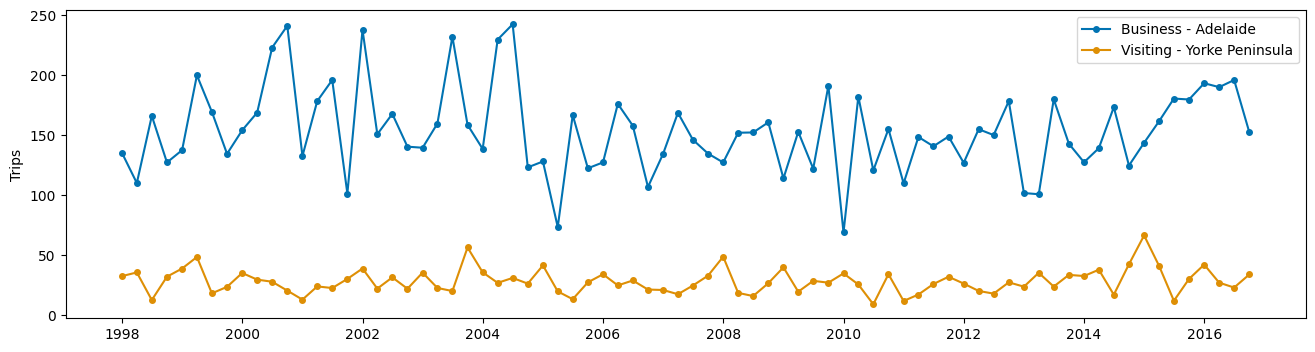

In [19]:
from sktime.utils.plotting import plot_series

plot_series(
    y.loc[("South Australia", "Adelaide", "Business")],
    y.loc[("South Australia", "Yorke Peninsula", "Visiting")],
    labels=[
        "Business - Adelaide",
        "Visiting - Yorke Peninsula",
    ]
)


#### Naive Forecaster


In [20]:
from sktime.forecasting.base import BaseForecaster

class CustomNaiveForecaster(BaseForecaster):
    """
    A simple naive forecaster
    
    Parameters
    ----------
    n : int
        Number of past values to use.
    """

    _tags = {
        "requires-fh-in-fit": False,
        
        "y_inner_mtype": [
            "pd.Series",
        ],
        "scitype:y": "univariate",
    }

    
    # Add hyperparameters in init!
    def __init__(
        self, n=1
    ):
        # 1. Set hyper-parameters
        self.n = n

        # 2. Initialize parent class
        super().__init__()

        # 3. Check hyper-parameters
        assert self.n > 0, "n must be greater than 0"

    def _fit(self, y, X, fh):
        """
        Fit necessary parameters.
        """
        
        self.value_ = y.iloc[-self.n:].mean()
        return self

    def _predict(self, fh, X):
        """
        Use forecasting horizon and optionally X to predict y
        """

        # During fit, BaseForecaster sets
        # self.cutoff to the latest cutoff time point
        index = fh.to_absolute_index(self.cutoff)
        y_pred = pd.Series(
            index=index,
            data=[self.value_ for _ in range(len(index))],
        )
        
        
        return y_pred

In [21]:
custom_naive_model = CustomNaiveForecaster()
custom_naive_model.fit(y)

CustomNaiveForecaster()

In [22]:
custom_naive_model.forecasters_

forecasters
South Australia Adelaide        Business  CustomNaiveForecaster()
                                Holiday   CustomNaiveForecaster()
                                Other     CustomNaiveForecaster()
                                Visiting  CustomNaiveForecaster()
                Adelaide Hills  Business  CustomNaiveForecaster()
...                                                           ...
Victoria        Wimmera         Visiting  CustomNaiveForecaster()
South Australia Yorke Peninsula Business  CustomNaiveForecaster()
                                Holiday   CustomNaiveForecaster()
                                Other     CustomNaiveForecaster()
                                Visiting  CustomNaiveForecaster()

[308 rows x 1 columns]

In [23]:
custom_naive_model.get_fitted_params()

{'forecasters':                                                       forecasters
 South Australia Adelaide        Business  CustomNaiveForecaster()
                                 Holiday   CustomNaiveForecaster()
                                 Other     CustomNaiveForecaster()
                                 Visiting  CustomNaiveForecaster()
                 Adelaide Hills  Business  CustomNaiveForecaster()
 ...                                                           ...
 Victoria        Wimmera         Visiting  CustomNaiveForecaster()
 South Australia Yorke Peninsula Business  CustomNaiveForecaster()
                                 Holiday   CustomNaiveForecaster()
                                 Other     CustomNaiveForecaster()
                                 Visiting  CustomNaiveForecaster()
 
 [308 rows x 1 columns],
 "forecasters.loc[('South Australia', 'Adelaide', 'Business'),'forecasters']": CustomNaiveForecaster(),
 "forecasters.loc[('South Australia', 'Adelaide', 

In [24]:
custom_naive_model.predict(fh=[1,2,3])

Trips
State           Region          Purpose  Quarter            
South Australia Adelaide        Business 2017Q1   152.428887
                                         2017Q2   152.428887
                                         2017Q3   152.428887
                                Holiday  2017Q1   147.101964
                                         2017Q2   147.101964
...                                                      ...
                Yorke Peninsula Other    2017Q2     1.407142
                                         2017Q3     1.407142
                                Visiting 2017Q1    33.672151
                                         2017Q2    33.672151
                                         2017Q3    33.672151

[924 rows x 1 columns]

#### Simple ensemble forecaster + free unit tests!

In [25]:
import pandas as pd
from sktime.forecasting.base import BaseForecaster

class SimpleEnsembleForecaster(BaseForecaster):
    """Simple ensemble forecaster.
    
    This forecaster fits a list of forecasters to the same training data and
    aggregates their predictions using a simple aggregation function.

    Parameters
    ----------
    forecasters : list of sktime forecasters
        List of forecasters to fit and aggregate.
    agg : str, optional (default="mean")
        Aggregation function to use. Must be one of "mean" or "median".
    """

    _tags = {
        # Model metadata
        "ignores-exogeneous-X": True,
        "requires-fh-in-fit": False,
        "X_inner_mtype": [
            "pd.DataFrame",
            "pd-multiindex",
            "pd_multiindex_hier",
        ],
        "y_inner_mtype": [
            "pd.DataFrame",
            "pd-multiindex",
            "pd_multiindex_hier",
        ],
        "scitype:y": "univariate",
    }

    # todo: add any hyper-parameters and components to constructor
    def __init__(
        self, forecasters, agg = "mean"
    ):
        # estimators should precede parameters
        #  if estimators have default values, set None and initialize below

        self.forecasters = forecasters
        self.agg = agg

        super().__init__()

        # Handle default values, being careful to not overwrite the hyper-parameters
        # as they were passed!

        # Parameter checking logic
        if agg not in ["mean", "median"]:
            raise ValueError(f"agg must be 'mean' or 'median', got {agg}")

        # if tags of estimator depend on component tags, set them
        for forecaster in self.forecasters:
            if forecaster.get_tag("requires-fh-in-fit"):
                self.set_tags({"requires-fh-in-fit": True})

    def _fit(self, y, X, fh):
        """Fit forecaster to training data.

        private _fit containing the core logic, called from fit. 
        Sets fitted model attributes ending in "_".

        Parameters
        ----------
        y : sktime time series object
            guaranteed to be of pd.Series
        fh : ForecastingHorizon or None, optional (default=None)
            The forecasting horizon with the steps ahead to to predict.
        X : sktime time series object, optional (default=None)
            guaranteed to be pd.DataFrame, or None

        Returns
        -------
        self : reference to self
        """

        self.forecasters_ = []
        for forecaster in self.forecasters:
            forecaster = forecaster.clone()
            forecaster.fit(y, X, fh)
            self.forecasters_.append(forecaster)

    def _predict(self, fh, X):
        """Forecast time series at future horizon.

        Parameters
        ----------
        fh : ForecastingHorizon or None, optional (default=None)
            The forecasting horizon with the steps ahead to to predict.
        X : sktime time series object, optional (default=None)
            guaranteed to be pd.DataFrame, or None

        Returns
        -------
        y_pred : sktime time series object
            should be of the same type as seen in _fit, as in "y_inner_mtype" tag
            Point predictions
        """
        y_preds = []
        for forecaster in self.forecasters_:
            y_preds.append(
                forecaster.predict(fh=fh, X=X)
            )

        y_column_name = y_preds[0].columns[0]
        aggregated = pd.concat(y_preds, axis=1).agg(self.agg, axis=1).to_frame(
            y_column_name
        )
        aggregated.index = y_preds[0].index
        aggregated = aggregated.sort_index()
        
        
        return aggregated
    
    def _update(self, y, X=None, update_params=True):
        """Update fitted parameters.

        Parameters
        ----------
        y : pd.Series
        X : pd.DataFrame
        update_params : bool, optional, default=True

        Returns
        -------
        self : an instance of self.
        """
        for forecaster in self.forecasters_:
            forecaster.update(y, X, update_params=update_params)
        return self
        

    @classmethod
    def get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            There are currently no reserved values for forecasters.

        Returns
        -------
        params : dict or list of dict, default = {}
            Parameters to create testing instances of the class
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
            `create_test_instance` uses the first (or only) dictionary in `params`
        """
        from sktime.forecasting.exp_smoothing import ExponentialSmoothing
        
        return [
            {
                "forecasters": [ExponentialSmoothing(random_state=0)],
                "agg": "mean",
            },
            {
                "forecasters": [ExponentialSmoothing(random_state=0), ExponentialSmoothing(random_state=0)],
                "agg": "median",
            },
        ]
    


In [26]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
model = SimpleEnsembleForecaster(
    forecasters=[ExponentialSmoothing(), NaiveForecaster()],
    agg="mean"
)

model.fit(y=y)
model.predict(fh=[1,2,3])

Trips
State             Region           Purpose  Quarter            
ACT               Canberra         Business 2017Q1   165.133297
                                            2017Q2   165.133297
                                            2017Q3   165.133297
                                   Holiday  2017Q1   179.645444
                                            2017Q2   179.645444
...                                                         ...
Western Australia Experience Perth Other    2017Q2    89.628523
                                            2017Q3    89.628523
                                   Visiting 2017Q1   413.951363
                                            2017Q2   413.951363
                                            2017Q3   413.951363

[924 rows x 1 columns]

**Free: unit tests to check your model!**

*  A comprehensive set of unit tests is immediately available for your new forecaster.
*  You can call these tests with `check_estimator`

In [27]:
from sktime.utils.estimator_checks import check_estimator


check_estimator(SimpleEnsembleForecaster, tests_to_exclude=["test_doctest_examples"])

All tests PASSED!


{'test_no_cross_test_side_effects_part1[SimpleEnsembleForecaster-0]': 'PASSED',
 'test_no_cross_test_side_effects_part1[SimpleEnsembleForecaster-1]': 'PASSED',
 'test_no_cross_test_side_effects_part2[SimpleEnsembleForecaster-0]': 'PASSED',
 'test_no_cross_test_side_effects_part2[SimpleEnsembleForecaster-1]': 'PASSED',
 'test_get_test_params[SimpleEnsembleForecaster]': 'PASSED',
 'test_create_test_instances_and_names[SimpleEnsembleForecaster]': 'PASSED',
 'test_has_common_interface[SimpleEnsembleForecaster]': 'PASSED',
 'test_set_params[SimpleEnsembleForecaster-0]': 'PASSED',
 'test_set_params[SimpleEnsembleForecaster-1]': 'PASSED',
 'test_no_between_test_case_side_effects[SimpleEnsembleForecaster-0-ForecasterFitPredictUnivariateWithX-0]': 'PASSED',
 'test_no_between_test_case_side_effects[SimpleEnsembleForecaster-0-ForecasterFitPredictUnivariateWithX-1]': 'PASSED',
 'test_no_between_test_case_side_effects[SimpleEnsembleForecaster-0-ForecasterFitPredictMultivariateNoX-0]': 'PASSED',
 't



### 1.4. Implementing a new transformer

![Transformations in a pipeline](imgs/transform_pipeline.png)

**Transformers tags**

```python
_tags = {
        "scitype:transform-input": "Series",
        # what is the scitype of X: Series, or Panel
        "scitype:transform-output": "Series",
        # what scitype is returned: Primitives, Series, Panel
        "scitype:instancewise": True,  # is this an instance-wise transform?
        "X_inner_mtype": "np.ndarray",  # which mtypes do _fit/_predict support for X?
        "y_inner_mtype": "None",  # which mtypes do _fit/_predict support for y?
        "fit_is_empty": True,
        "univariate-only": False,
        "capability:inverse_transform": False,
}
```
As an practical example of transformation, we will re-implement the `LogTransformer`, which simply takes the log of the series. 

In [28]:
import numpy as np
from sktime.transformations.base import BaseTransformer

class LogTransformer(BaseTransformer):

    _tags = {
        #"scitype:transform-input": "Series",
        # what is the scitype of X: Series, or Panel
        #"scitype:transform-output": "Series",
        # what scitype is returned: Primitives, Series, Panel
        "scitype:instancewise": True,  # is this an instance-wise transform?
        "X_inner_mtype": "np.ndarray",  # which mtypes do _fit/_predict support for X?
        "y_inner_mtype": "None",  # which mtypes do _fit/_predict support for y?
        "fit_is_empty": True,
        "univariate-only": False,
        "capability:inverse_transform": True,
    }

    def __init__(self, offset=0, scale=1):
        self.offset = offset
        self.scale = scale
        super().__init__()

    def _transform(self, X, y=None):
        """Transform X and return a transformed version.

        private _transform containing the core logic, called from transform

        Parameters
        ----------
        X : 2D np.ndarray
            Data to be transformed
        y : ignored argument for interface compatibility
            Additional data, e.g., labels for transformation

        Returns
        -------
        Xt : 2D np.ndarray
            transformed version of X
        """
        offset = self.offset
        scale = self.scale
        Xt = np.log(scale * (X + offset))
        return Xt

    def _inverse_transform(self, X, y=None):
        """Inverse transform X and return an inverse transformed version.

        core logic

        Parameters
        ----------
        X : 2D np.ndarray
            Data to be transformed
        y : ignored argument for interface compatibility
            Additional data, e.g., labels for transformation

        Returns
        -------
        Xt : 2D np.ndarray
            inverse transformed version of X
        """
        offset = self.offset
        scale = self.scale
        Xt = (np.exp(X) / scale) - offset
        return Xt
    
    @classmethod
    def get_test_params(cls, parameter_set="default"):
        return [
            {"offset": 0, "scale": 1},
            {"offset": 1, "scale": 2},
        ]

transformer = LogTransformer()
transformer.fit_transform(y)

Trips
State           Region          Purpose  Quarter          
South Australia Adelaide        Business 1998Q1   4.905850
                                         1998Q2   4.700365
                                         1998Q3   5.112197
                                         1998Q4   4.845450
                                         1999Q1   4.923250
...                                                    ...
                Yorke Peninsula Visiting 2015Q4   3.400037
                                         2016Q1   3.735564
                                         2016Q2   3.289695
                                         2016Q3   3.124952
                                         2016Q4   3.516671

[23408 rows x 1 columns]

In [29]:
check_estimator(
    LogTransformer(),
    tests_to_exclude=["test_doctest_examples"]
)

All tests PASSED!


{'test_no_cross_test_side_effects_part1[LogTransformer]': 'PASSED',
 'test_no_cross_test_side_effects_part2[LogTransformer]': 'PASSED',
 'test_get_test_params[LogTransformer]': 'PASSED',
 'test_create_test_instances_and_names[LogTransformer]': 'PASSED',
 'test_has_common_interface[LogTransformer]': 'PASSED',
 'test_set_params[LogTransformer]': 'PASSED',
 'test_no_between_test_case_side_effects[LogTransformer-TransformerFitTransformSeriesUnivariate-0]': 'PASSED',
 'test_no_between_test_case_side_effects[LogTransformer-TransformerFitTransformSeriesUnivariate-1]': 'PASSED',
 'test_no_between_test_case_side_effects[LogTransformer-TransformerFitTransformSeriesMultivariate-0]': 'PASSED',
 'test_no_between_test_case_side_effects[LogTransformer-TransformerFitTransformSeriesMultivariate-1]': 'PASSED',
 'test_no_between_test_case_side_effects[LogTransformer-TransformerFitTransformSeriesUnivariateWithY-0]': 'PASSED',
 'test_no_between_test_case_side_effects[LogTransformer-TransformerFitTransformS

#### Transformation with inner forecaster: creating an Imputer

* Transformations also accept forecasters! Lets create an imputer that fills in-sample values with a forecaster.

```python
imputer = ImputeWithForecaster(
    forecaster=AutoETS(auto=True),
)
imputer.fit_transform(y)
```

In [30]:
from sktime.registry import all_estimators

all_estimators(
    estimator_types="forecaster",
    as_dataframe=True,
    filter_tags="handles-missing-data",
).head()

,name,object
0,ARIMA,<class 'sktime.forecasting.arima._pmdarima.ARI...
1,AutoARIMA,<class 'sktime.forecasting.arima._pmdarima.Aut...
2,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
3,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
4,DirRecTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...


In [31]:
from sktime.transformations.base import BaseTransformer


class ImputeWithForecaster(BaseTransformer):
    
    _tags = {
        "X_inner_mtype": ["pd.DataFrame", "pd-multiindex", "pd_multiindex_hier"],
        "y_inner_mtype": ["pd.DataFrame", "pd-multiindex", "pd_multiindex_hier"],
        "univariate-only": False,
        "fit_is_empty": False,
        "capability:inverse_transform": True,
        
    }

    def __init__(self, forecaster, fh=None):
        self.forecaster = forecaster
        self.fh = fh
        super().__init__()

        # Assert that forecaster can predict in-sample and
        # handles missing value
        forecaster_predicts_insample = self.forecaster.get_tag("capability:insample", False)
        forecaster_handles_missing_data = self.forecaster.get_tag("handles-missing-data", False)

        if not (forecaster_predicts_insample or forecaster_handles_missing_data):
            raise ValueError(
                "Forecaster must be able to predict in-sample or handle missing data"
            )
        
        requires_fh_in_fit = self.forecaster.get_tag("requires-fh-in-fit", True)
        if requires_fh_in_fit:
            if fh is None:
                raise ValueError("fh must be provided when requires-fh-in-fit is True")
            


    def _fit(self, X, y=None):
        """Fit the forecaster"""
        self.forecaster_ = self.forecaster.clone()
        self.forecaster_.fit(y=X, X=y, fh=self.fh)
    

    def _transform(self, X, y=None):
        """Transform X and return a transformed version.

        private _transform containing the core logic, called from transform

        Parameters
        ----------
        X : pd.Series or pd.DataFrame
            Data to be transformed
        y : pd.DataFrame, default=None
            Additional data, e.g., labels for transformation

        Returns
        -------
        Xt : pd.Series or pd.DataFrame, same type as X
            transformed version of X, detrended series
        """
        fh = X.index.get_level_values(-1).unique()
        y_pred = self.forecaster_.predict(fh=fh)

        # Replace missing values in X with predictions
        X = X.copy()
        for col in X.columns:
            X[col] = X[col].fillna(y_pred[col])
        return X
    
    def _inverse_transform(self, X, y=None):
        return X


    @classmethod
    def get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return ``"default"`` set.


        Returns
        -------
        params : dict or list of dict, default = {}
            Parameters to create testing instances of the class
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            ``MyClass(**params)`` or ``MyClass(**params[i])`` creates a valid test
            instance.
            ``create_test_instance`` uses the first (or only) dictionary in ``params``
        """
        from sktime.forecasting.ets import AutoETS
        from sktime.forecasting.naive import NaiveForecaster

        params1 = {"forecaster": AutoETS()}
        params2 = {"forecaster" : NaiveForecaster()}

        return [params1, params2]

In [32]:
import numpy as np

y_missing = y.copy()
# Set some random values to nan
np.random.seed(42)  # for reproducibility
mask = np.random.rand(len(y_missing)) < 0.3  # 30% chance for each value
y_missing.loc[mask, 'Trips'] = np.nan
y_missing

Trips
State           Region          Purpose  Quarter            
South Australia Adelaide        Business 1998Q1   135.077690
                                         1998Q2   109.987316
                                         1998Q3   166.034687
                                         1998Q4   127.160464
                                         1999Q1          NaN
...                                                      ...
                Yorke Peninsula Visiting 2015Q4    29.965222
                                         2016Q1    41.911665
                                         2016Q2          NaN
                                         2016Q3    22.758809
                                         2016Q4    33.672151

[23408 rows x 1 columns]

In [33]:
from sktime.forecasting.theta import ThetaForecaster

try:
    ThetaForecaster().fit(y_missing)
except ValueError as e:
    print(e)

ThetaForecaster cannot handle missing data (nans), but y passed contained missing data.


In [34]:
from sktime.forecasting.naive import NaiveForecaster


imputer = ImputeWithForecaster(
    forecaster=NaiveForecaster(strategy="last")
)

forecaster = imputer * ThetaForecaster(deseasonalize=False)
forecaster.fit(y_missing)
forecaster.predict(fh=[1,2,3])

Trips
State           Region          Purpose  Quarter            
South Australia Adelaide        Business 2017Q1   149.107796
                                         2017Q2   149.107512
                                         2017Q3   149.107228
                                Holiday  2017Q1   159.124703
                                         2017Q2   159.069603
...                                                      ...
                Yorke Peninsula Other    2017Q2     2.721969
                                         2017Q3     2.736115
                                Visiting 2017Q1    32.340754
                                         2017Q2    32.328660
                                         2017Q3    32.316565

[924 rows x 1 columns]

In [35]:
check_estimator(
    ImputeWithForecaster,
    tests_to_exclude=["test_doctest_examples"]
)

All tests PASSED!


{'test_no_cross_test_side_effects_part1[ImputeWithForecaster-0]': 'PASSED',
 'test_no_cross_test_side_effects_part1[ImputeWithForecaster-1]': 'PASSED',
 'test_no_cross_test_side_effects_part2[ImputeWithForecaster-0]': 'PASSED',
 'test_no_cross_test_side_effects_part2[ImputeWithForecaster-1]': 'PASSED',
 'test_get_test_params[ImputeWithForecaster]': 'PASSED',
 'test_create_test_instances_and_names[ImputeWithForecaster]': 'PASSED',
 'test_has_common_interface[ImputeWithForecaster]': 'PASSED',
 'test_set_params[ImputeWithForecaster-0]': 'PASSED',
 'test_set_params[ImputeWithForecaster-1]': 'PASSED',
 'test_no_between_test_case_side_effects[ImputeWithForecaster-0-TransformerFitTransformSeriesUnivariateWithY-0]': 'PASSED',
 'test_no_between_test_case_side_effects[ImputeWithForecaster-0-TransformerFitTransformSeriesUnivariateWithY-1]': 'PASSED',
 'test_no_between_test_case_side_effects[ImputeWithForecaster-1-TransformerFitTransformSeriesUnivariateWithY-0]': 'PASSED',
 'test_no_between_test_c

## 2. Contributing to sktime


**Why?**

* **Enhance your skills**: get to work with amazing developers and researchers worldwide!
* **Share your work**: multiply the reach of your work by sharing it with the community.
* **Help others**: help others by sharing your work and knowledge.


### Directly

If you want to contribute to sktime, you can do so by:

* Creating a new issue, to help solving bugs and adding new features
* Creating a pull request, to add new features or fix bugs
* Join the discord channel, where you can ask questions and get help from the community.
* Present at the sktime meetup.

### Indirectly: creating your own 2nd or 3rd party library

You can also create your own library and enjoy every feature of sktime! An example of 2nd-party library is [Prophetverse](https://prophetverse.com).

In this case, you would like to import `parametrize_with_checks` and add it to your test directory:


```python

import pytest  # noqa: F401
from sktime.utils.estimator_checks import check_estimator, parametrize_with_checks

from yourpackage import YourModel


@parametrize_with_checks([YourModel])
def test_sktime_api_compliance(obj, test_name):
    """Test the sktime contract for Prophet and HierarchicalProphet."""
    check_estimator(obj, tests_to_run=test_name, raise_exceptions=True)
```

